In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
# import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os
# import pathlib

print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


In [2]:
image_datas = glob('./datas/*/*.png')
class_name = ["apple", "beef", "milk","noodle","potato"]
dic = {"apple":0, "beef":1, "milk":2, "noodle":3, "potato":4}

In [3]:
X = []
Y = []
for imagename in image_datas:
    image = Image.open(imagename)
    image = image.resize((128, 128))
    image = np.array(image)
    X.append(image)
    label = imagename.split('/')[2]
    label = dic[label]
    Y.append(label)

In [4]:
X = np.array(X)    
Y = np.array(Y)    

In [5]:
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, random_state=44)

train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels[..., tf.newaxis]

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((2372, 128, 128, 3), (2372, 1), (594, 128, 128, 3), (594, 1))

In [6]:
## training set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (2372,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 552, 1: 395, 2: 553, 3: 560, 4: 312}

In [7]:
## test set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(test_labels, (594,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 141, 1: 102, 2: 134, 3: 138, 4: 79}

In [8]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]

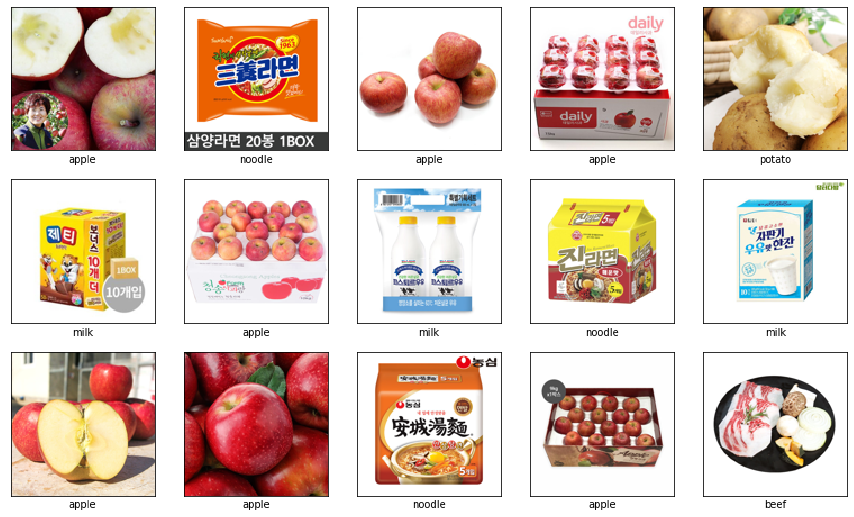

In [9]:
## Data 확인
plt.figure(figsize=(15,9))
for i in range(15):
    img_idx = np.random.randint(0, 2372)
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_name[train_labels[img_idx][0]])

In [10]:
# pixel값을 0~1사이 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [11]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(2372, 128, 128, 3) (2372, 5)
(594, 128, 128, 3) (594, 5)


In [12]:
## Hyper-parameters
learning_rate = 0.01
N_EPOCHS = 10
N_BATCH = 50
N_CLASS = 5

In [13]:
## dataset 구성    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=2372).batch(N_BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(N_BATCH)

In [14]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(128, 128, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(5, activation='softmax'))
    return model

In [15]:
## Create model, compile & summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

In [16]:
## Parameters for training
steps_per_epoch = N_TRAIN//N_BATCH
validation_steps = N_TEST//N_BATCH
print(steps_per_epoch, validation_steps)

47 11


In [17]:
## Training
history = model.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 47 steps, validate for 11 steps
Epoch 1/10
47/47 [==============================] - 25s 523ms/step - loss: 3.2373 - accuracy: 0.2889 - val_loss: 1.4530 - val_accuracy: 0.3400
Epoch 2/10
47/47 [==============================] - 24s 513ms/step - loss: 1.4326 - accuracy: 0.3368 - val_loss: 1.3500 - val_accuracy: 0.4145
Epoch 3/10
47/47 [==============================] - 24s 506ms/step - loss: 1.2858 - accuracy: 0.4552 - val_loss: 1.1382 - val_accuracy: 0.5236
Epoch 4/10
47/47 [==============================] - 23s 497ms/step - loss: 1.1584 - accuracy: 0.5383 - val_loss: 1.0073 - val_accuracy: 0.6345
Epoch 5/10
47/47 [==============================] - 24s 510ms/step - loss: 0.9534 - accuracy: 0.6456 - val_loss: 0.8923 - val_accuracy: 0.6945
Epoch 6/10
47/47 [==============================] - 23s 495ms/step - loss: 0.7998 - accuracy: 0.7054 - val_loss: 0.8255 - val_accuracy: 0.7327
Epoch 7/10
47/47 [==============================] - 23s 492ms/step - loss: 0.6864 - accuracy: 0.7502

In [18]:
model.evaluate(test_dataset)

12/12 [==============================] - 2s 150ms/step - loss: 0.7080 - accuracy: 0.7879


[0.7079757576187452, 0.7878788]

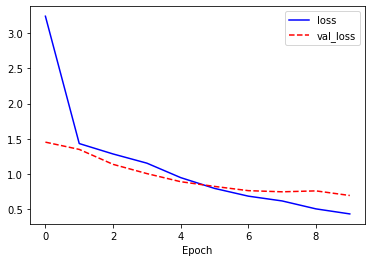

In [19]:
## Plot losses
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

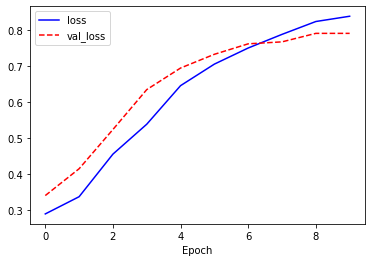

In [20]:
## Plot losses
plt.plot(history.history['accuracy'], 'b-', label='loss')
plt.plot(history.history['val_accuracy'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
## 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                100*np.max(predictions_array),
                                class_name[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(N_CLASS), class_name, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(N_CLASS), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

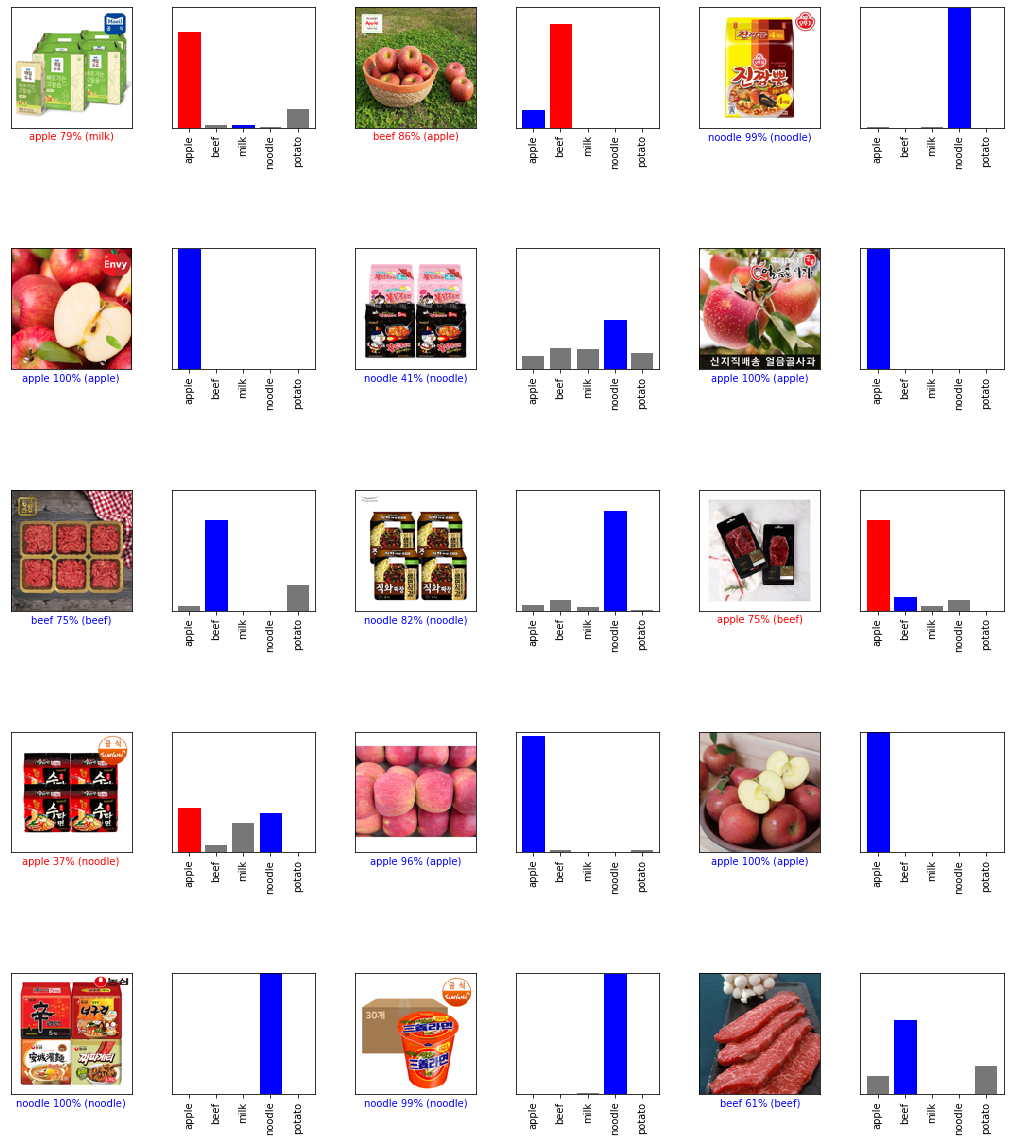

In [22]:
rnd_idx = np.random.randint(1, N_TEST//N_BATCH)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break